# **1. Loading & Cleaning Data**

In [230]:
import yfinance as yf

gold_ticker = yf.Ticker("GC=F")

df = gold_ticker.history(period="1y", interval='1h')

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)

display(df.shape)

display(df.head(3))

(5773, 4)

,Open,High,Low,Close
Datetime,,,,
2023-09-20 18:00:00-04:00,1952.000000,1952.199951,1950.199951,1951.599976
2023-09-20 19:00:00-04:00,1951.500000,1951.500000,1949.400024,1949.599976
2023-09-20 20:00:00-04:00,1949.599976,1949.699951,1944.500000,1945.099976


# **Creating Constants needed**

In [231]:
WINDOW = 7

PNL = {
    'WIN': 1,
    'LOSS': -1
}

SIGNALS = {
    'BUY': 1,
    'SELL': -1
}

# RRR is 1 SL = TP = 1 STD

STD_FACTORS = {
    'ENTRY': 2,
    'SL': 1, # is calculated from entry
    'TP': 1 # is calculated from entry
}

POSITIONS_NATURE = {
    '1': 'Buy',
    '-1': 'Sell'
}

# **2. Defining the Strategy (Mean Reversion)**

### We will create Columns needed

In [232]:
# Low
df['Mean_L'] = df['Low'].rolling(window=WINDOW).mean()
df['STD_L'] = df['Low'].rolling(window=WINDOW).std()
df['Z-Score_L'] = (df['Low'] - df['Mean_L']) / df['STD_L']

# High
df['Mean_H'] = df['High'].rolling(window=WINDOW).mean()
df['STD_H'] = df['High'].rolling(window=WINDOW).std()
df['Z-Score_H'] = (df['High'] - df['Mean_H']) / df['STD_H']

df.dropna(inplace=True)
df.reset_index(inplace=True)

display(df.head(3))

,Datetime,Open,High,Low,Close,Mean_L,STD_L,Z-Score_L,Mean_H,STD_H,Z-Score_H
0,2023-09-21 00:00:00-04:00,1948.300049,1948.500000,1947.699951,1947.800049,1946.885690,2.331260,0.349280,1949.328544,1.907629,-0.434332
1,2023-09-21 01:00:00-04:00,1947.800049,1948.800049,1946.800049,1948.500000,1946.399990,1.824843,0.219229,1948.842843,1.426960,-0.029990
2,2023-09-21 02:00:00-04:00,1948.400024,1950.300049,1947.400024,1948.099976,1946.114275,1.378933,0.932423,1948.671422,1.085860,1.499850


### Overview

<Axes: ylabel='Z-Score'>

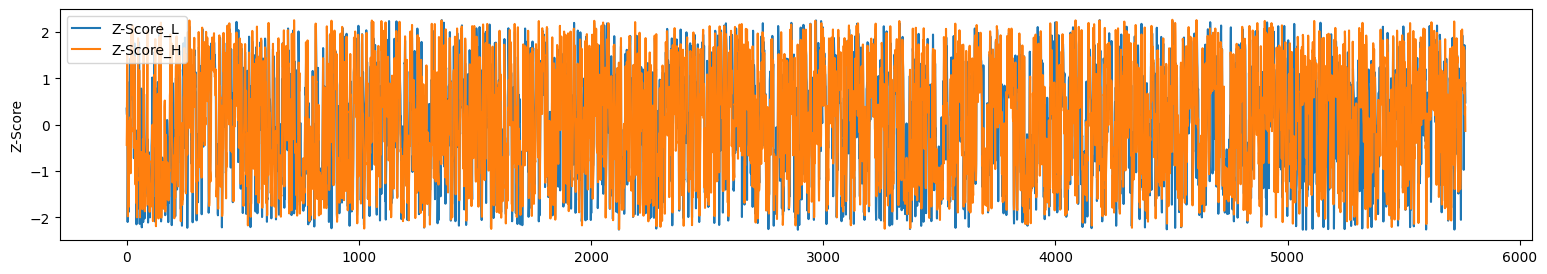

In [233]:
df[['Z-Score_L', 'Z-Score_H']].plot(kind='line', figsize=(19, 3), ylabel="Z-Score")

Z-Score_L
False    0.957344
True     0.042656
Name: proportion, dtype: float64

,Z-Score_L,Z-Score_H
max,2.258415,2.265128
min,-2.264885,-2.253621


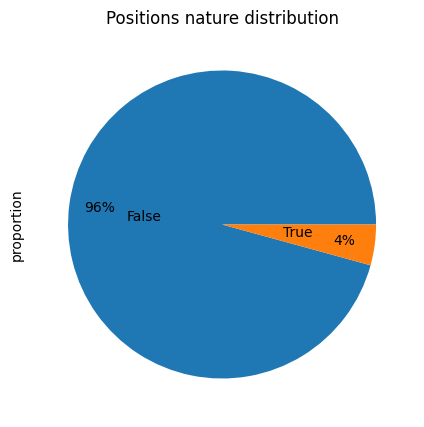

In [234]:
# same for Z-Score_H
stats = (abs(df['Z-Score_L']) > STD_FACTORS['ENTRY']).value_counts(normalize=True)

display(stats)

stats.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Positions nature distribution",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.4
)

df[['Z-Score_L', 'Z-Score_H']].agg(['max', 'min'])

### Generate buy/sell signals

In [235]:
df['Signal'] = 0  # Default to hold/no position
df.loc[df['Z-Score_L'] < -STD_FACTORS['ENTRY'], 'Signal'] = SIGNALS['BUY'] # Buy signal
df.loc[df['Z-Score_H'] > STD_FACTORS['ENTRY'], 'Signal']= SIGNALS['SELL']  # Sell signal

# **3. Implementing Stop Loss and Take Profit**

In [236]:
from helpers import Trade

# Initialize trade tracking columns
df['Position'] = 0  # Track if we're in a trade (1 for long, -1 for short)
df['Entry_Price'] = 0.0  # Track entry price
df['Exit_Price'] = 0.0  # Track exit price
df['PnL'] = 0.0  # Track Profit and Loss for each trade

# Simulate the strategy with SL/TP
trade = Trade()

for i in range(0, len(df)):
    if not trade.on: 
        # Check if there's a BUY signal
        if df.loc[i, 'Signal'] == SIGNALS['BUY']:
            trade.on = True
            trade.entry = (df.loc[i, 'Mean_L']  - STD_FACTORS['ENTRY'] * df.loc[i, 'STD_L']) 
            trade.tp = trade.entry + STD_FACTORS['TP'] * df.loc[i, 'STD_L']
            trade.sl = trade.entry - STD_FACTORS['SL'] * df.loc[i, 'STD_L']
            df.loc[i, ['Position', 'Entry_Price']] = [SIGNALS['BUY'], trade.entry]
        # Check if there's a SELL signal
        if df.loc[i, 'Signal'] == SIGNALS['SELL']:
            trade.on = True
            trade.entry = (df.loc[i, 'Mean_H']  + STD_FACTORS['ENTRY'] * df.loc[i, 'STD_H'])
            trade.tp = trade.entry - STD_FACTORS['TP'] * df.loc[i, 'STD_H']
            trade.sl = trade.entry + STD_FACTORS['SL'] * df.loc[i, 'STD_H']
            df.loc[i, ['Position', 'Entry_Price']] = [SIGNALS['SELL'], trade.entry]
    else:
        # Track price movement for Stop Loss or Take Profit
        # In case of BUY
        if trade.is_buy:
            if df.loc[i, 'Low'] <= trade.sl:  # SL hit
                df.loc[i, 'Exit_Price'] = trade.sl
                df.loc[i, 'PnL'] = PNL['LOSS']
                trade.on = False  # Exit trade
            elif df.loc[i, 'High'] > trade.tp:  # TP hit
                df.loc[i, 'Exit_Price'] = trade.tp
                df.loc[i, 'PnL'] = PNL['WIN']
                trade.on = False  # Exit trade

        # In case of SELL
        if trade.is_sell:
            if df.loc[i, 'High'] >= trade.sl:  # SL hit
                df.loc[i, 'Exit_Price'] = trade.sl
                df.loc[i, 'PnL'] = PNL['LOSS']
                trade.on = False  # Exit trade
            elif df.loc[i, 'Low'] < trade.tp:  # TP hit
                df.loc[i, 'Exit_Price'] = trade.tp
                df.loc[i, 'PnL'] = PNL['WIN']
                trade.on = False  # Exit trade

# **4. Backtesting & Overview**

In [237]:
# Calculate cumulative profit/loss
df['Cumulative_PnL'] = df['PnL'].cumsum()

# Filter rows where we had a trade exit
trades = df[df['PnL'] != 0]

# Summary statistics
total_trades = len(trades)
total_pnl = df['Cumulative_PnL'].iloc[-1]  # Total profit/loss
win_rate = round(trades['PnL'].value_counts(normalize=True).loc[1], 3)

print(f"Total Trades: {total_trades}")
print(f"Total Profit/Loss: {total_pnl} RR")
print(f"Win rate: {win_rate * 100}%")

Total Trades: 271
Total Profit/Loss: 145.0 RR
Win rate: 76.8%


- **PnL**

<Axes: title={'center': 'PnL'}, xlabel='Datetime', ylabel='RR | %'>

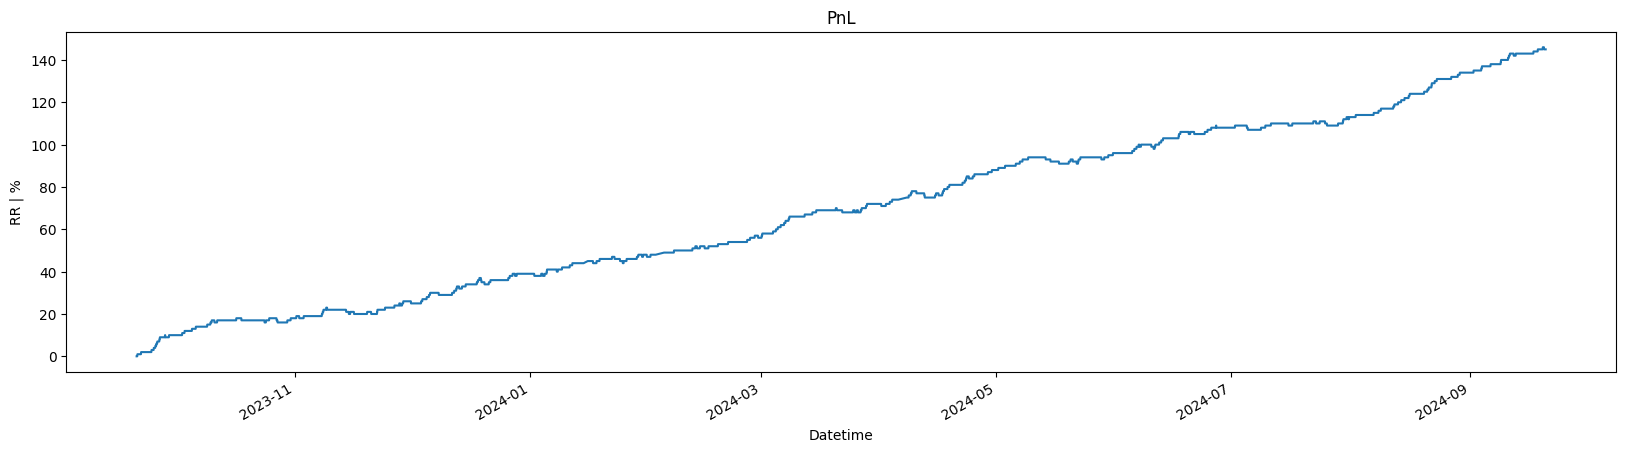

In [238]:
df.set_index('Datetime', inplace=True)

df['Cumulative_PnL'].plot(
    kind='line', 
    figsize=(20, 5), 
    title="PnL",
    ylabel="RR | %",
)

- **PnL-Drawdown** (not from Equity)

<Axes: title={'center': 'PnL-Drawdown'}, xlabel='Datetime', ylabel='RR | %'>

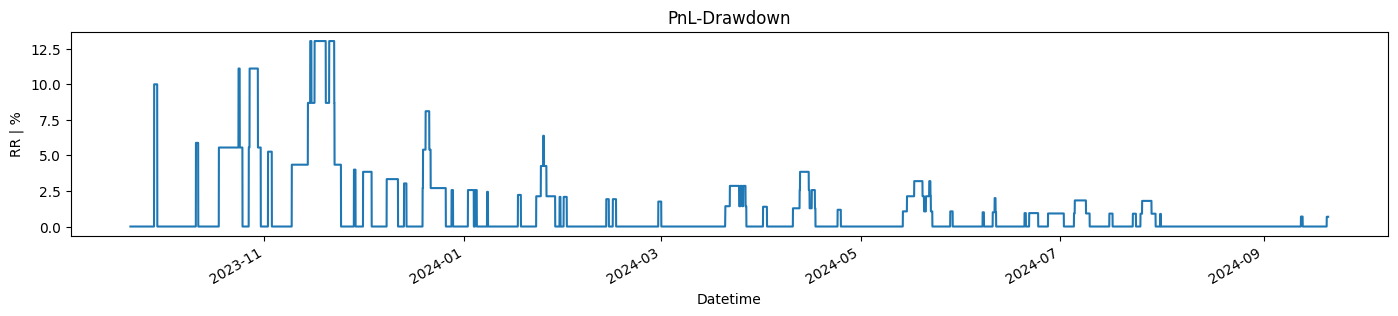

In [239]:
df['Peak'] = df['Cumulative_PnL'].cummax()

df['Drawdown'] = (df['Peak'] - df['Cumulative_PnL']) / df['Peak']

# df['Drawdown'] = df.apply(lambda row: ((row['Peak'] - row['Cumulative_PnL']) / row['Peak']) if row['Peak'] != 0 else 0, axis=1)

# import numpy as np
# df['Drawdown'] = np.where(df['Peak'] != 0, (df['Peak'] - df['Cumulative_PnL']) / df['Peak'], 0)

(df['Drawdown'] * 100).plot(
    kind='line', 
    figsize=(17, 3), 
    title="PnL-Drawdown",
    ylabel="RR | %",
)

In [240]:
print(f"Max PnL-drawdown is {round(100 * df['Drawdown'].max(), 2)} %")

Max PnL-drawdown is 13.04 %


> ___________________________________________________________________________________________________________________________________________________________________________________________

# **5. A study on Drawdown**

In [241]:
# [TODO] periods where drawdown (over 50%) happened

# **6. Overview on positions**

<Axes: xlabel='Datetime'>

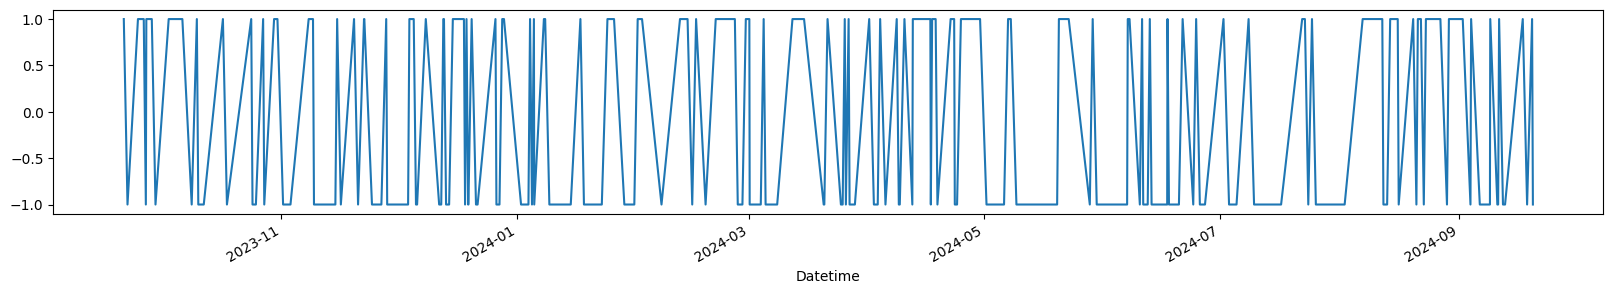

In [242]:
filtrty = df['Position'] != 0

df.loc[filtrty, 'Position'].plot(kind='line', figsize=(20, 3))

<Axes: title={'center': 'Positions nature distribution'}, ylabel='proportion'>

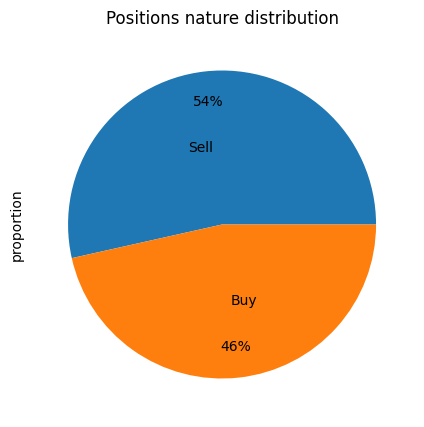

In [243]:
positions_nature_distribution_df = df.loc[filtrty, 'Position'].value_counts(normalize=True)

positions_nature_distribution_df.index = [POSITIONS_NATURE[str(x)] for x in positions_nature_distribution_df.index.to_list()]

positions_nature_distribution_df

positions_nature_distribution_df.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Positions nature distribution",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.5
)

# [TODO] probability distribution

In [244]:
# [TODO] max consecutive wins & losses